In [ ]:
#Import all needed libraries
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score,recall_score,f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#import moderate dimentia dataset then add each file to an array with the label 1
directory_path = r"C:\Users\sbcon\OneDrive\Desktop\ISE_Final_project\Moderate Dementia"
files = os.listdir(directory_path)
jpg_files = [file for file in files if file.lower().endswith(".jpg")]
file_data = [[file, 1] for file in jpg_files]

#import non demented dataset then add each file to an array with the label 0
directory_path1 = r"C:\Users\sbcon\OneDrive\Desktop\ISE_Final_project\Non Demented"
files1 = os.listdir(directory_path1)
jpg_files1 = [file for file in files1 if file.lower().endswith(".jpg")]
file_data.extend([[file, 0] for file in jpg_files1])

#import moderate dimentia dataset then add each file to an array with the label 1
directory_path2 = r"C:\Users\sbcon\OneDrive\Desktop\ISE_Final_project\Mild Dementia"
files2 = os.listdir(directory_path2)
jpg_files2 = [file for file in files2 if file.lower().endswith(".jpg")]
file_data.extend([[file, 1] for file in jpg_files2])

In [ ]:
#put the jpg files and labels into a dataframe
df = pd.DataFrame(file_data, columns=["Brain Scan", "Label"])

#create to empty lists to hold the images and data as we prepare the jpg files to be
#evaluated by the cnn
processed_images = []
labels = []

#go throught the data frame row by row and process the images for the cnn
for index, row in df.iterrows():
    if row['Label'] == 1:
        if row['Brain Scan'] in jpg_files2: 
            image_path = os.path.join(directory_path2, row['Brain Scan']) 
        else:
            image_path = os.path.join(directory_path, row['Brain Scan'])
    else:
        image_path = os.path.join(directory_path1, row['Brain Scan'])
    try:
        image = load_img(image_path, target_size=(496, 248))
        image_array = img_to_array(image) / 255.0
        processed_images.append(image_array)
        labels.append(row['Label'])
    except Exception as e:
        print(f"Error opening image {row['Brain Scan']}: {e}")
#create an array of the process images
x = np.array(processed_images)
#create an array of the corresponding labels
y = np.array(labels)

#split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
#flatten the data to feed it into the autoencoder 
x_train = x_train.reshape((x_train.shape[0],496*248*3))
x_test = x_test.reshape((x_test.shape[0], 496*248*3))

#create the autoencoder 
input_img = Input(shape=(496*248*3,))
hidden_1 = Dense(128,activation ='relu')(input_img)
code = Dense(32, activation = 'relu')(hidden_1)
hidden_2 = Dense(128,activation= 'relu')(code)
output_img = Dense(496*248*3,activation='sigmoid')(hidden_2)

#compile and fit the autoencoder
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam',loss = 'binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=3)

Epoch 1/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 462ms/step - loss: 0.3965
Epoch 2/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 137s 573ms/step - loss: 0.3515
Epoch 3/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 176s 735ms/step - loss: 0.3448


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


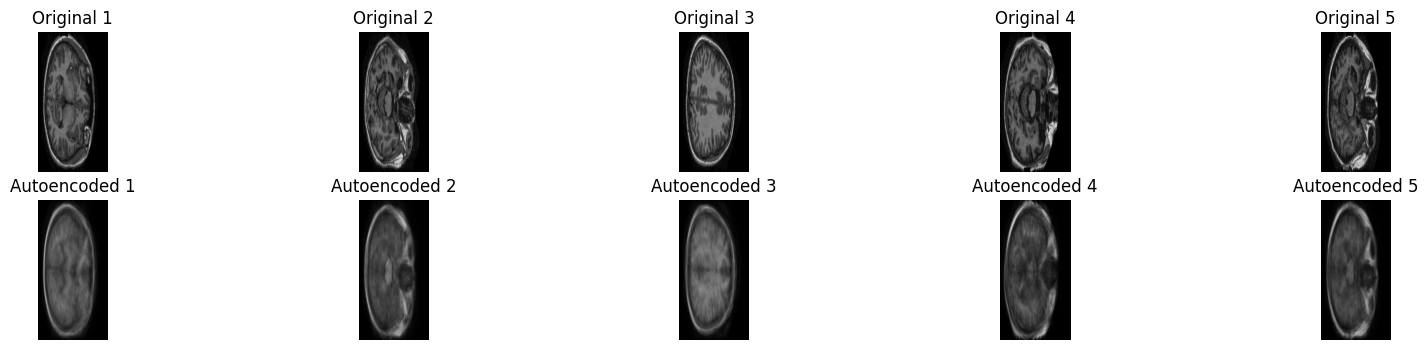

In [ ]:
#plot pictures before and after they have gone through the autoencoder
def plot_autoencoder_outputs(autoencoder, n, img_shape):
    decoded_imgs = autoencoder.predict(x_test[:n])
    plt.figure(figsize=(20, 4))

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(img_shape))
        ax.axis('off')
        ax.set_title(f"Original {i + 1}") 

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(img_shape))
        ax.axis('off')
        ax.set_title(f"Autoencoded {i + 1}")  

    plt.show()

plot_autoencoder_outputs(autoencoder, 5, (496, 248, 3))

In [ ]:
#create the cnn
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[496, 248, 3], kernel_regularizer=l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(tf.keras.layers.Dropout(0.4))

cnn.add(tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(tf.keras.layers.Dropout(0.4))

cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#reshape x_train and x_test so that they can be fed into the cnn
x_train = x_train.reshape(-1, 496, 248, 3)
x_test = x_test.reshape(-1, 496, 248, 3)

#fit the cnn
cnn.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=2, callbacks=[early_stopping]) 
# predict the y_test
y_pred = cnn.predict(x_test)
#make the predictions either 0 or 1
y_pred = (y_pred > 0.5)

C:\Users\sbcon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
239/239 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5971 - loss: 0.7905 - val_accuracy: 0.9862 - val_loss: 0.2055
Epoch 2/2
239/239 ━━━━━━━━━━━━━━━━━━━━ 169s 707ms/step - accuracy: 0.8748 - loss: 0.3611 - val_accuracy: 0.9941 - val_loss: 0.1287
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step


Accuracy: 0.9940968122786304
Recall: 0.9963289280469897
Precision: 0.9926847110460864
F1 Score: 0.9945034811286185
Confusion Matrix:
[[1169   10]
 [   5 1357]]
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.8997 - loss: 0.3083 - val_accuracy: 0.9937 - val_loss: 0.1176
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.8998 - loss: 0.2966 - val_accuracy: 0.9965 - val_loss: 0.1091
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 186s 777ms/step - accuracy: 0.9143 - loss: 0.2749 - val_accuracy: 0.9933 - val_loss: 0.0981
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 191s 801ms/step - accuracy: 0.9161 - loss: 0.2719 - val_accuracy: 0.9976 - val_loss: 0.0923
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 174s 726ms/step - accuracy: 0.9368 - loss: 0.2391 - val_accuracy: 0.9953 - val_loss: 0.1044
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 540ms/step - accuracy: 0.9457 - loss: 0.2261 - val_accuracy: 0.9984 - val_loss: 0.0893
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 539ms/ste

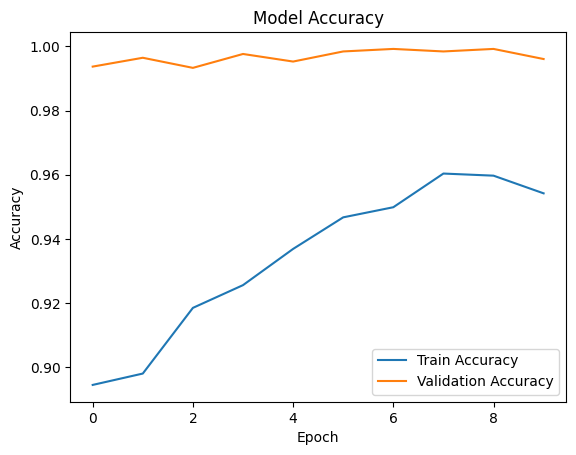

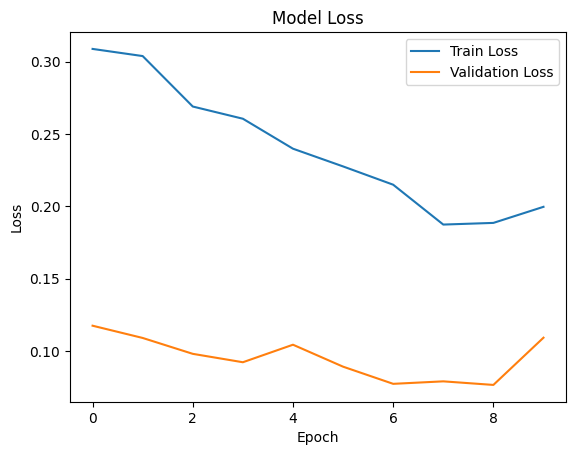

In [ ]:
#score the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt

#run the cnn again in order to get data for graphs
history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

#plot the data
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
